In [1]:
import pandas as pd 
from subs.energy_api import *
import urllib3

# Suppress only the single InsecureRequestWarning from urllib3 needed for bypassing SSL verification
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

df_carbon_forecast_indexed =carbon_api_forecast()


In [2]:
df_carbon_forecast_indexed

,FieldName,Region,Value
EffectiveTime,,,
2024-02-17 20:00:00,CO2_INTENSITY_FORECAST,ALL,200.9168
2024-02-17 20:30:00,CO2_INTENSITY_FORECAST,ALL,207.9352
2024-02-17 21:00:00,CO2_INTENSITY_FORECAST,ALL,211.3738
2024-02-17 21:30:00,CO2_INTENSITY_FORECAST,ALL,211.9682
2024-02-17 22:00:00,CO2_INTENSITY_FORECAST,ALL,208.3744
2024-02-17 22:30:00,CO2_INTENSITY_FORECAST,ALL,210.2571
2024-02-17 23:00:00,CO2_INTENSITY_FORECAST,ALL,215.8810
2024-02-17 23:30:00,CO2_INTENSITY_FORECAST,ALL,217.5741


In [5]:
co2_stats_prior_day, df_carbon_intensity_recent = carbon_api_intensity()

/Users/saeed/Documents/GitHub/telegram-energy-api/subs/energy_api.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
df_carbon_intensity_recent

,FieldName,Region,Value
EffectiveTime,,,
2024-02-16 20:00:00,CO2_INTENSITY,ALL,272.0
2024-02-16 20:15:00,CO2_INTENSITY,ALL,263.0
2024-02-16 20:30:00,CO2_INTENSITY,ALL,264.0
2024-02-16 20:45:00,CO2_INTENSITY,ALL,255.0
2024-02-16 21:00:00,CO2_INTENSITY,ALL,260.0
...,...,...,...
2024-02-17 18:45:00,CO2_INTENSITY,ALL,199.0
2024-02-17 19:00:00,CO2_INTENSITY,ALL,202.0
2024-02-17 19:15:00,CO2_INTENSITY,ALL,200.0


In [7]:
co2_stats_prior_day

{'mean': 216.80208333333334, 'min': 169.0, 'max': 272.0}

In [9]:
df_ = status_classification(df_carbon_forecast_indexed,co2_stats_prior_day)

In [72]:
df = df_.copy()

In [34]:
df

,FieldName,Region,Value,status_compared_to_yesterday,status_compared_to_EU
EffectiveTime,,,,,
2024-02-17 20:00:00,CO2_INTENSITY_FORECAST,ALL,200.9168,medium,low
2024-02-17 20:30:00,CO2_INTENSITY_FORECAST,ALL,207.9352,medium,low
2024-02-17 21:00:00,CO2_INTENSITY_FORECAST,ALL,211.3738,medium,low
2024-02-17 21:30:00,CO2_INTENSITY_FORECAST,ALL,211.9682,medium,low
2024-02-17 22:00:00,CO2_INTENSITY_FORECAST,ALL,208.3744,medium,low
2024-02-17 22:30:00,CO2_INTENSITY_FORECAST,ALL,210.2571,medium,low
2024-02-17 23:00:00,CO2_INTENSITY_FORECAST,ALL,215.8810,medium,low
2024-02-17 23:30:00,CO2_INTENSITY_FORECAST,ALL,217.5741,medium,low


In [52]:
np.arange(100, 600, 165)

array([100, 265, 430, 595])

In [94]:
def find_optimized_relative_periods(df):
    # Normalize CO2 values to a 0-1 scale
    df['normalized'] = (df['Value'] - df['Value'].min()) / (df['Value'].max() - df['Value'].min())

    # Define thresholds for relative categorization
    low_threshold = df['normalized'].quantile(0.33)
    high_threshold = df['normalized'].quantile(0.66)

    # Categorize each timestamp
    df['category'] = pd.cut(df['normalized'], bins=[-np.inf, low_threshold, high_threshold, np.inf], labels=['Low', 'Medium', 'High'])

    # Find consecutive periods with the same category
    df['group'] = (df['category'] != df['category'].shift()).cumsum()

    # Prepare summary text
    summary_text = "Considering absolute CO2 emission values, determined by data trends, distinct periods are identified as:\n\n"

    # Initialize a dictionary to store concatenated periods for each category
    period_summary = {'Low': [], 'Medium': [], 'High': []}

    # Group by category and group to concatenate periods
    for category, group in df.groupby(['category', 'group']):
        start_time = group.index.min().strftime('%H:%M')
        end_time = group.index.max().strftime('%H:%M')
        # For periods that start and end at the same time, just show one time
        period_str = f"{start_time} to {end_time}" if start_time != end_time else f"{start_time}"
        period_summary[category[0]].append(period_str)

    # Format the summary text for each category
    for category in ['Low', 'Medium', 'High']:
        if period_summary[category]:
            periods = ', '.join(period_summary[category])
            summary_text += f"{category} CO2 Emission Period: {periods}.\n"
        else:
            summary_text += f"{category} CO2 Emission Period: No specific periods identified.\n"

    return summary_text,df,period_summary

# Assuming df_ is your DataFrame with 'Value' column and DateTimeIndex
summary_text,df_test , period_summary= find_optimized_relative_periods(df_)
print(summary_text)


Considering absolute CO2 emission values, distinct periods are identified as:

Low CO2 Emission Period: 20:00 to 20:30, 22:00.
Medium CO2 Emission Period: 21:00, 22:30.
High CO2 Emission Period: 21:30, 23:00 to 23:30.



/var/folders/n8/5rf_2zc91lx1ffhm5t27hrsw0000gn/T/ipykernel_2495/2481872867.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for category, group in df.groupby(['category', 'group']):


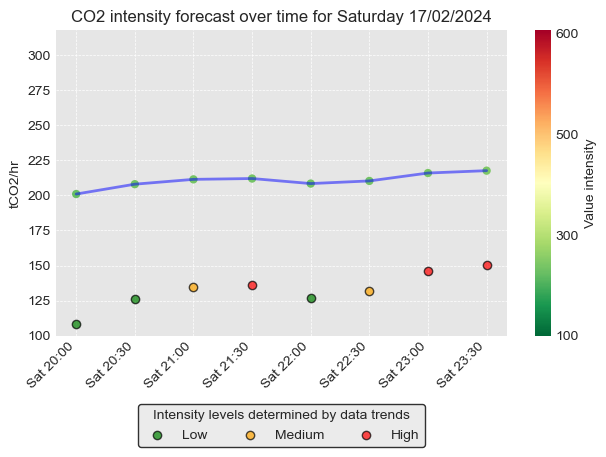

In [128]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

today_date = datetime.datetime.now()
today_date= today_date.strftime("%A %d/%m/%Y")
# First, ensure 'EffectiveTime' is the DataFrame's index and is of datetime type
df.index = pd.to_datetime(df.index)

# Setting up the colormap and norm for value intensity
norm = plt.Normalize(100, 600)
cmap = plt.get_cmap('RdYlGn_r')  # Using a built-in colormap that goes from green to red

# Creating the plot
fig, ax = plt.subplots()

# Plotting the line
ax.plot(df.index, df['Value'], color='b', alpha=0.5,linewidth=2)  # Line plot in grey for the trend

# Overlaying a scatter plot for value intensity
sc = ax.scatter(df.index, df['Value'], c=df['Value'], cmap=cmap, norm=norm, edgecolor='none')


# Ensure df.index is in the correct datetime format and set as the DataFrame's index
custom_ticks = df.index.to_series().dt.strftime("%a %H:%M")

# Set custom ticks and labels on the x-axis
ax.set_xticks(df.index)  # Set ticks at each index point
ax.set_xticklabels(custom_ticks, rotation=45, ha="right")  # Set custom formatted labels



# Customizing the colorbar
cbar = fig.colorbar(sc, ax=ax, orientation="vertical", label="Value intensity")
cbar.set_ticks(np.arange(100, 600, 165))  # Adding ticks for every 200 values
cbar.set_ticklabels(["100", "300", "500", "600"])  # Custom labels for the colorbar

# Creating a twin y-axis for normalized values
ax2 = ax.twinx()
ax2.set_yticks([])  # Removes the y-ticks
ax2.set_yticklabels([])  # Removes the y-tick labels

# Categorizing and coloring based on 'category'
colors = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}
for category, color in colors.items():
    # Filter df for each category and plot on ax2 with specific color
    df_cat = df[df['category'] == category]
    ax2.scatter(df_cat.index, df_cat['normalized'], color=color, label=category, alpha=0.7, edgecolor='black')

ax2.set_ylim([-.2, 5])  # Setting y-axis limits
# Adjusting plot appearance
ax.grid(True, which='both', linestyle='--', linewidth=0.5)  # Adding a grid for readability
ax.set_ylim([100, df['Value'].max()+100])  # Setting y-axis limits
ax.set_ylabel('tCO2/hr')
ax.set_title(f"CO2 intensity forecast over time for {today_date}")
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4, frameon=True, edgecolor='black',
           title='Intensity levels determined by data trends')


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [130]:
import numpy as np 
def optimize_categorize_periods(df):
    # Define thresholds for CO2 emission categorization
    low_threshold, high_threshold = 250, 500

    # Categorize each timestamp
    df['category'] = pd.cut(df['Value'], bins=[-np.inf, low_threshold, high_threshold, np.inf], labels=['Low', 'Medium', 'High'])

    # Find consecutive periods with the same category
    df['group'] = (df['category'] != df['category'].shift()).cumsum()

    # Initialize summary text
    summary_text = "Based on the forecasted CO2 emissions data for today, distinct periods are identified as:\n\n"

    # Initialize a dictionary to store concatenated periods for each category
    period_summary = {'Low': [], 'Medium': [], 'High': []}

    # Group by category and group to concatenate periods
    for category, group in df.groupby(['category', 'group']):
        start_time = group.index.min().strftime('%H:%M')
        end_time = group.index.max().strftime('%H:%M')
        period_str = f"{start_time} to {end_time}" if start_time != end_time else f"{start_time}"
        period_summary[category[0]].append(period_str)

    # Format the summary text for each category
    for category in ['Low', 'Medium', 'High']:
        if period_summary[category]:
            periods = ', '.join(period_summary[category])
            summary_text += f"{category} CO2 Emission Periods: {periods}.\n"
        else:
            summary_text += f"{category} CO2 Emission Periods: No specific periods identified.\n"

    return summary_text

# Assuming df_ is your DataFrame with 'Value' column and DateTimeIndex
summary_text = optimize_categorize_periods(df_)
print(summary_text)


Based on the forecasted CO2 emissions data for today, distinct periods are identified as:

Low CO2 Emission Periods: 20:00 to 23:30.
Medium CO2 Emission Periods: No specific periods identified.
High CO2 Emission Periods: No specific periods identified.



/var/folders/n8/5rf_2zc91lx1ffhm5t27hrsw0000gn/T/ipykernel_2495/449615099.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for category, group in df.groupby(['category', 'group']):


In [132]:
def create_combined_gpt_prompt(date, eu_summary_text, quantile_summary_text):
    prompt = (
        f"Based on the forecasted CO2 emissions data for {date}, here are two analyses:\n\n"
        "1. **EU Standards Analysis**:\n"
        f"{eu_summary_text}\n\n"
        "2. ** Data Analysis**:\n"
        f"{quantile_summary_text}\n\n"
        "Given these detailed analyses, please provide advice on how to align energy consumption to minimize environmental impact, "
        "First start with an overview based on the EU standards. Then, considering both the broader EU standards and the more nuanced day-to-day variations.  "
        # "Highlight the optimal times for energy usage, especially focusing on the absolute lowest CO2 emission periods identified in the detailed analysis. "
        "The goal is to offer guidance that helps individuals effectively reduce their carbon footprint, "
        "using the insights from both the EU standards perspective and the data analysis. Make it short and cocise and give users time categories"
    )

    return prompt



# Assume 'eu_summary_text' is your summary based on EU standards
# 'quantile_summary_text' is the output from 'find_relative_periods' function
date = str(df_.index[0])
eu_summary_text = optimize_categorize_periods(df_)
quantile_summary_text,_,_ = find_optimized_relative_periods(df_)  # Generate this based on your DataFrame
prompt = create_combined_gpt_prompt(date, eu_summary_text, quantile_summary_text)
print(prompt)


Based on the forecasted CO2 emissions data for 2024-02-17 20:00:00, here are two analyses:

1. **EU Standards Analysis**:
Based on the forecasted CO2 emissions data for today, distinct periods are identified as:

Low CO2 Emission Periods: 20:00 to 23:30.
Medium CO2 Emission Periods: No specific periods identified.
High CO2 Emission Periods: No specific periods identified.


2. ** Data Analysis**:
Considering absolute CO2 emission values, distinct periods are identified as:

Low CO2 Emission Period: 20:00 to 20:30, 22:00.
Medium CO2 Emission Period: 21:00, 22:30.
High CO2 Emission Period: 21:30, 23:00 to 23:30.


Given these detailed analyses, please provide advice on how to align energy consumption to minimize environmental impact, First start with an overview based on the EU standards. Then, considering both the broader EU standards and the more nuanced day-to-day variations.  The goal is to offer guidance that helps individuals effectively reduce their carbon footprint, using the ins

/var/folders/n8/5rf_2zc91lx1ffhm5t27hrsw0000gn/T/ipykernel_2495/449615099.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for category, group in df.groupby(['category', 'group']):
/var/folders/n8/5rf_2zc91lx1ffhm5t27hrsw0000gn/T/ipykernel_2495/2481872867.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for category, group in df.groupby(['category', 'group']):


In [65]:
import openai
import os
import datetime
from datetime import timedelta


def create_message(forecast_start_date, co2_values,user_name):
    class Message:
        def __init__(self, system, user):
            self.system = system
            self.user = user

    start_datetime = datetime.datetime.strptime(forecast_start_date, "%Y-%m-%d %H:%M:%S")
    
    # Generate hours list based on the start_datetime and the length of co2_values
    hours = [(start_datetime + timedelta(minutes=30 * i)).strftime('%H:%M') for i in range(len(co2_values))]
    
    time_with_co2 = ", ".join(
        f"{hour} (CO2: {value} g/kWh)" for hour, value in zip(hours, co2_values)
    )

    # system_template = (
    #     f"Forecasted CO2 emissions data from {forecast_start_date}, updating every 30 minutes, is provided below. "
    #     f"Based on this, you are to give energy usage advice. Identify the most environmentally friendly hours "
    #     f"for energy consumption to minimize environmental impact, they are hours with the lowest values. Use the format: Most environmental friendly hours hh:mm, "
    #     f"hh:mm. Consider high CO2 > 500, low CO2 < 250, and medium for values in between and mention them if and only if any exists "
    #     f"\n\nCO2 values and corresponding times are: {time_with_co2}"
    #     f"\n\nProvide advice on the optimal time periods for energy consumption, do not need to give CO2 values to users."
    #     f"\n\n start with greeting user {user_name}, based on time {forecast_start_date}. Don't tell them they can ask questions. "
    # )
    system_template = prompt

    user_template = "When are the best and worst time periods, on average, to use energy today from the environmental impact perspective in format of hour:minute?"

    system = system_template
    user = user_template

    m = Message(system=system, user=user)
    return m


def opt_gpt_summarise():
    # Ensure your API key is correctly set in your environment variables
    openai.api_key = os.getenv("OPENAI_API_KEY")

    # Construct the messages
    msg = create_message(
        forecast_start_date=str(df_.index[0]), co2_values=df_.Value.values,user_name = 'Saeed'
    )

    messages = [
        {"role": "system", "content": msg.system}
        # {"role": "user", "content": msg.user},
    ]

    try:
        # Making the API call
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",  # or "gpt-3.5-turbo" based on your subscription
            messages=messages,
            temperature= 1,
            max_tokens=600,  # Adjust the number of tokens as needed
            n=1,  # Number of completions to generate
            stop=None,  # Specify any stopping criteria if needed
        )

        # Extracting the response
        # generated_text = response.choices[0].message['content'].strip()
        generated_text = response.choices[0].message.content.strip()

        return generated_text
    except Exception as e:
        return str(e)


In [199]:
from subs.openai_script import *

gpt_recom = opt_gpt_summarise(prompt_text)

In [200]:
print(gpt_recom)

📋 CO2 Emission Brief & Energy Efficiency Guide:
- 🇪🇺 EU Standards Forecast: Low Emission from 20:00 to 23:30

- 🔍 Data Trend Schedule: 
  - 🟢 Low Emission: 20:00 to 20:30, 22:00
  - 🟡 Medium Emission: 21:00, 22:30
  - 🔴 High Emission: 21:30, 23:00 to 23:30

- 💡 Energy-Saving Actions:
  - 🟢 During low emission periods (20:00 to 20:30, 22:00), consider running energy-intensive appliances like dishwashers or laundry machines.
  - 🟡 In medium emission periods (21:00, 22:30), reduce energy usage by adjusting thermostat settings or using energy-saving modes on electronics.
  - 🔴 During high emission periods (21:30, 23:00 to 23:30), avoid unnecessary energy consumption by limiting the use of multiple high-power devices simultaneously.


In [198]:
prompt_data = """
🌍 CO2 Emissions Forecast for 2024-02-17:

1. **EU Standards Analysis** 🇪🇺:
- 🟢 Low Emission: 20:00 to 23:30
- No medium or high emission periods identified.

2. **Data Trend Analysis** 🔍:
- 🟢 Low Emission: 20:00 to 20:30, 22:00
- 🟡 Medium Emission: 21:00, 22:30
- 🔴 High Emission: 21:30, 23:00 to 23:30
"""

structure_example = """
📋 CO2 Emission Brief & Energy Efficiency Guide:
- 🇪🇺 EU Standards Forecast: ONLY report it \n
- 🔍 Data Trend Schedule: ONLY report \n
- 💡 Energy-Saving Actions: ONLY give an example per category of Data Trend
"""

prompt_text = f"""
📊 Given the CO2 emission forecasts and detailed analysis for 2024-02-17, let's explore how we can adjust our energy consumption to minimize our environmental impact. Our aim is to provide straightforward and practical advice, utilizing both EU standards and specific data trends.

{prompt_data}

BTW, in low emission periods, users can use high energy intensive devices and are not advised to reduce much theri energy \n\n

💡 In periods of low emissions, feel free to use energy-intensive appliances without much concern for reduction.

👉 Please use the following format for your response: {structure_example}
"""
print(prompt_text)


📊 Given the CO2 emission forecasts and detailed analysis for 2024-02-17, let's explore how we can adjust our energy consumption to minimize our environmental impact. Our aim is to provide straightforward and practical advice, utilizing both EU standards and specific data trends.


🌍 CO2 Emissions Forecast for 2024-02-17:

1. **EU Standards Analysis** 🇪🇺:
- 🟢 Low Emission: 20:00 to 23:30
- No medium or high emission periods identified.

2. **Data Trend Analysis** 🔍:
- 🟢 Low Emission: 20:00 to 20:30, 22:00
- 🟡 Medium Emission: 21:00, 22:30
- 🔴 High Emission: 21:30, 23:00 to 23:30


BTW, in low emission periods, users can use high energy intensive devices and are not advised to reduce much theri energy 



💡 In periods of low emissions, feel free to use energy-intensive appliances without much concern for reduction.

👉 Please use the following format for your response: 
📋 CO2 Emission Brief & Energy Efficiency Guide:
- 🇪🇺 EU Standards Forecast: ONLY report it 

- 🔍 Data Trend Schedule: O

In [143]:
expected_response= """CO2 Emission Brief & Energy Efficiency Guide:\n
EU Standards Forecast: Low CO2 emissions all day.\nData Trend Schedule:\n
Low Emissions: 8:00-8:30 PM, 10:00 PM. Ideal for high energy use.\n
Medium Emissions: 9:00 PM, 10:30 PM. Be careful with your consumption. \n 
High Emissions: 9:30 PM, 11:00-11:30 PM. Delay heavy energy tasks.\n
Energy-Saving Actions:\nBoil only needed water; use microwaves for smaller meals.\n
Run full dishwashers at cooler settings.\n
Cook smart: use lids, right size pots for hobs, avoid opening oven frequently, keep it clean, and consider a slow cooker.\n
Implementing these steps during appropriate emission periods enhances energy efficiency and contributes to lower bills and reduced environmental impact."""

In [144]:
print(expected_response)

CO2 Emission Brief & Energy Efficiency Guide:

EU Standards Forecast: Low CO2 emissions all day.
Data Trend Schedule:

Low Emissions: 8:00-8:30 PM, 10:00 PM. Ideal for high energy use.

Medium Emissions: 9:00 PM, 10:30 PM. Be careful with your consumption. 
 
High Emissions: 9:30 PM, 11:00-11:30 PM. Delay heavy energy tasks.

Energy-Saving Actions:
Boil only needed water; use microwaves for smaller meals.

Run full dishwashers at cooler settings.

Cook smart: use lids, right size pots for hobs, avoid opening oven frequently, keep it clean, and consider a slow cooker.

Implementing these steps during appropriate emission periods enhances energy efficiency and contributes to lower bills and reduced environmental impact.
